In [1]:
import cvxopt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from data_gen import *
SEED=0

# T1
## Primal-SVM

In [2]:
class Primal_SVM:
    def __init__(self,transform_fn=None):
        self.transform_fn=transform_fn
    def fit(self,data):
        X=data[0]
        if self.transform_fn:
            X=self.transform_fn.fit_transform(X)
        y=data[1]
        N,d=X.shape # N: the num of samples  d: 不增广1的时候的维数
        X=np.hstack((np.ones((N,1)),X))
        y=y.reshape((N,1))

        Q=np.array((np.hstack((np.zeros((1+d,1)),np.vstack([np.zeros((1,d)),np.eye(d)])))),dtype=np.float)
        p=np.zeros((d+1,1),dtype=np.float)
        A=-y*X
        c=np.full(N,-1.0).reshape((N,1))#注意类型要是小数类型, 不能是整数

        Q=cvxopt.matrix(Q)
        p=cvxopt.matrix(p)
        A=cvxopt.matrix(A)
        c=cvxopt.matrix(c)

        solution=cvxopt.solvers.qp(Q,p,A,c)
        weight=solution['x']
        self.b=weight[0]
        self.w=np.array(weight[1:]).flatten()

    def decision_fn(self,X):
        if self.transform_fn:
            X=self.transform_fn.fit_transform(X)
        return self.b+X@self.w

    def predict(self,X):
        return np.sign(self.decision_fn(X))
    
    def eval(self,X,y):
        pred=self.predict(X)
        mistake_indices = np.where(pred!=y)[0]
        accuracy = (X.shape[0]-len(mistake_indices))/X.shape[0]
        return accuracy
# X=np.array([[1,1],[2,2],[2,0],[0,0],[1,0],[0,1]])
# y=np.array([1]*3+[-1]*3,dtype=np.float)
# data=(X,y)
# model=Primal_SVM()
# model.fit(data)
# model.eval(data[0],data[1])

In [3]:
# SGD法求SVM的解
# X=np.array([[1,1],[2,2],[2,0],[0,0],[1,0],[0,1]])
# y=np.array([1]*3+[-1]*3)
# X=np.hstack((np.ones((6,1)),X))
# w0=np.array([0,0,0])
# w=w0
# lr=0.1
# for e in range(100):
#     g=((1-y*(X@w)>0)*(-y*X.T)).T
#     print('epoch ',e)
#     for i in range(6):
#         w=w-lr*g[i]
#         print(w)

## dual SVM

In [4]:
class Dual_SVM:
    def __init__(self,epsilon=1e-9,transform_fn=None):
        self.epsilon=epsilon
        self.transform_fn=transform_fn

    def fit(self,data):
        X=data[0]#注意此处的X也是不增广1的X
        if self.transform_fn:
            X=self.transform_fn.fit_transform(X)
        y=data[1]
        N,d=X.shape

        Q=np.zeros((N,N))
        for i in range(N):
            for j in range(N):
                Q[i,j]=y[i]*y[j]*X[i,:]@X[j,:].T

        Q=np.array((Q),dtype=np.float)
        p=np.full((N,1),-1,dtype=np.float)
        A=-np.eye(N,dtype=np.float)#ppt上的公式有问题
        c=np.full((N,1),0.0)#注意类型要是小数类型, 不能是整数
        r=y.reshape((1,N))
        v=0.0

        Q=cvxopt.matrix(Q)
        p=cvxopt.matrix(p)
        A=cvxopt.matrix(A)
        c=cvxopt.matrix(c)
        r=cvxopt.matrix(r)
        v=cvxopt.matrix(v)

        solution=cvxopt.solvers.qp(Q,p,A,c,r,v)
        alpha=np.array(solution['x'])
        w=np.sum(alpha*y.reshape((N,1))*X,axis=0)
        idx=np.where(alpha>self.epsilon)[0][0]#先取index的list再取list的第一个元素
        b=y[idx]-X[idx,:]@w

        self.alpha=alpha
        self.w=w
        self.b=b

        self.SV=X[np.where(self.alpha.flatten()>self.epsilon)]
    
    def decision_fn(self,X):
        if self.transform_fn:
            X=self.transform_fn.fit_transform(X)
        return self.b+X@self.w

    def predict(self,X):
        return np.sign(self.decision_fn(X))
    
    def eval(self,X,y):
        pred=self.predict(X)
        mistake_indices = np.where(pred!=y)[0]
        accuracy = (X.shape[0]-len(mistake_indices))/X.shape[0]
        return accuracy

# X=np.array([[2,2],[-2,-2],[2,-2],[-2,2]],dtype=np.float)
# y=np.array([1]*2+[-1]*2,dtype=np.float)
# fn=PolynomialFeatures(degree=2,include_bias=False)
# model=Dual_SVM(transform_fn=fn)
# model.fit((X,y))
# hat_y=model.predict(X)

## kernel SVM

In [5]:
class Kernel_SVM():
    def __init__(self,kernel_name,epsilon=1e-7):
        linear_kernel=lambda x1,x2,gamma:x1.T@x2
        square_kernel=lambda x1,x2,gamma: (1+gamma*x1.T@x2)**2
        cubic_kernel=lambda x1,x2,gamma: (1+gamma*x1.T@x2)**3
        quartic_kernel=lambda x1,x2,gamma: (1+gamma*x1.T@x2)**4
        rbf_kernel=lambda x1,x2,gamma: np.exp(-gamma*np.linalg.norm(x1-x2)**2)

        self.epsilon=epsilon
        
        if kernel_name=='square':
            self.kernel_fn=square_kernel
            self.transform_fn=PolynomialFeatures(degree=2,include_bias=False)
        elif kernel_name=='cubic':
            self.kernel_fn=cubic_kernel
            self.transform_fn=PolynomialFeatures(degree=3,include_bias=False)
        elif kernel_name=='quartic':
            self.kernel_fn=quartic_kernel
            self.transform_fn=PolynomialFeatures(degree=4,include_bias=False)
        elif kernel_name=='rbf':
            self.kernel_fn=rbf_kernel
        else :
            self.kernel_fn=linear_kernel
            self.transform_fn=PolynomialFeatures(degree=1,include_bias=False)
        
        self.kernel_name=kernel_name

    def fit(self,data,gamma=1):
        X=data[0]#注意此处的X是不增广1不升维的X
        y=data[1]
        N,d=X.shape
        self.X=X
        self.y=y.reshape((N,1))
        self.gamma=gamma

        Q=np.zeros((N,N))
        for i in range(N):
            for j in range(N):
                Q[i,j]=y[i]*y[j]*self.kernel_fn(X[i,:].T,X[j,:].T,gamma)

        Q=np.array(Q,dtype=np.float)
        p=np.full((N,1),-1,dtype=np.float)
        A=-np.eye(N,dtype=np.float)
        c=np.full((N,1),0.0)#注意类型要是小数类型, 不能是整数
        r=y.reshape((1,N))
        v=0.0

        Q=cvxopt.matrix(Q)
        p=cvxopt.matrix(p)
        A=cvxopt.matrix(A)
        c=cvxopt.matrix(c)
        r=cvxopt.matrix(r)
        v=cvxopt.matrix(v)

        solution=cvxopt.solvers.qp(Q,p,A,c,r,v)
        self.alpha=np.array(solution['x'])
        # w=np.sum(alpha*y.reshape((N,1))*transform_fn.fit_transform(X),axis=0)
        idx=np.where(self.alpha>self.epsilon)[0][0]#先取index的list再取list的第一个元素
        # b=y[idx]-transform_fn.fit_transform(X[idx,:].reshape((1,-1)))@w
        # pred=np.sign(transform_fn.fit_transform(X)@w+b)

        if self.kernel_name!='rbf':
            self.b=y[idx]-(self.alpha*self.y).T@self.kernel_fn(self.X.T,self.X[idx,:],self.gamma) # (1,n)@ # (n,d).T.T@(d,)
        else:
            self.b=y[idx]-(self.alpha*self.y).T@[self.kernel_fn(self.X[n,:],self.X[idx,:],self.gamma) for n in range(self.X.shape[0])]#(1,N)@ (N,)

        self.SV=self.X[np.where(self.alpha.flatten()>self.epsilon)]

        # print('alpha= \n ',solution['x'])
        # print('w= ',w)
        # print('b= ',b)
        # return b,w,transform_fn

    def predict(self,X):
        return np.sign(self.decision_fn(X))

    def decision_fn(self,X):
        if self.kernel_name!='rbf':
            s=self.kernel_fn(X.T,self.X.T,self.gamma)@(self.alpha*self.y)+self.b #(m,d).T.T@(d,n)=(m,n) #(m,n)@(n,1)
        else:
            s=np.zeros((X.shape[0],1))
            for m in range(X.shape[0]):
                tmp=np.zeros(self.X.shape[0]) #(N,)
                for n in range(self.X.shape[0]):
                    tmp[n]=self.kernel_fn(self.X[n,:],X[m,:],self.gamma)
                s[m]=(self.alpha*self.y).T@tmp + self.b # (N,1).T @(N,)
        # return np.sign(s)
        return s
    
    def eval(self,X,y):
        pred=self.predict(X).flatten()#(N,1)与(N,)向量不能直接比较是否对应元素相等
        mistake_indices = np.where(pred!=y)[0]
        accuracy = (X.shape[0]-len(mistake_indices))/X.shape[0]
        return accuracy


# X=np.array([[1,1],[2,2],[2,0],[0,0],[1,0],[0,1]])
# y=np.array([1]*3+[-1]*3,dtype=np.float).reshape((X.shape[0],1))
# model=Kernel_SVM('rbf')
# model.fit((X,y),gamma=0.1)

# T2

In [6]:
def plot_svm_res(data,model,axes,plot_sv=True):
    X=data[0]
    y=data[1]
    def plot_predictions(model,axes):
        x0s = np.linspace(axes[0], axes[1], 30)
        x1s = np.linspace(axes[2], axes[3], 30)
        x0, x1 = np.meshgrid(x0s, x1s)
        X_ = np.c_[x0.ravel(), x1.ravel()]
        pred=model.decision_fn(X_)
        y_pred = pred.reshape(x0.shape)
        # ax=plt.contourf(x0, x1, np.sign(y_pred), cmap=plt.cm.brg, alpha=0.2)
        cs=plt.contour(x0,x1,y_pred,linewidths=2,levels=[-1,0,1],alpha=0.6)
        # plt.colorbar()
        plt.clabel(cs)
    plt.scatter(X[(y==1).flatten(),0],X[(y==1).flatten(),1],marker='.',color='green')
    plt.scatter(X[(y==-1).flatten(),0],X[(y==-1).flatten(),1],marker='*',color='blue')
    if plot_sv:
        plt.scatter(model.SV[:,0],model.SV[:,1],marker='o',color='pink',alpha=0.6)
    plot_predictions(model,axes)

data=data_generator([-5,0],np.eye(2),[0,5],np.eye(2),400,seed=SEED)
X_train,X_test,y_train,y_test=train_test_split(data[0],data[1],train_size=0.8,test_size=0.2)
train_data=(X_train,y_train)
test_data=(X_test,y_test)
axes=[-8, 4, -4, 8]

     pcost       dcost       gap    pres   dres
 0:  3.2951e-02  5.4758e+01  1e+03  2e+00  2e+03
 1:  1.7874e-01 -2.3700e+02  4e+02  9e-01  8e+02
 2:  2.6884e-01 -2.4907e+02  4e+02  7e-01  7e+02
 3:  5.6325e-01 -1.8593e+02  3e+02  4e-01  4e+02
 4:  1.0002e+00 -1.6451e+02  2e+02  2e-01  2e+02
 5:  1.3382e+00 -1.4064e+02  1e+02  1e-01  1e+02
 6:  1.4172e+00 -6.8217e+00  8e+00  6e-03  6e+00
 7:  1.0807e+00  6.0763e-01  5e-01  1e-15  1e-14
 8:  1.0370e+00  8.5081e-01  2e-01  9e-16  1e-14
 9:  1.0156e+00  1.0128e+00  3e-03  1e-15  6e-15
10:  1.0150e+00  1.0150e+00  3e-05  1e-15  1e-14
11:  1.0150e+00  1.0150e+00  3e-07  1e-15  1e-14
Optimal solution found.
primal svm train accuracy: 1.0
primal svm test accuracy: 1.0
     pcost       dcost       gap    pres   dres
 0: -2.1124e+01 -4.0993e+01  1e+03  3e+01  2e+00
 1: -2.4881e+01 -2.1501e+01  4e+02  1e+01  9e-01
 2: -6.0128e+01 -4.5100e+01  4e+02  1e+01  7e-01
 3: -7.5132e+01 -2.9223e+01  3e+02  6e+00  4e-01
 4: -2.2307e+01 -5.3029e+00  2e+02 

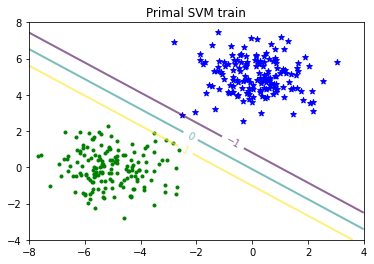

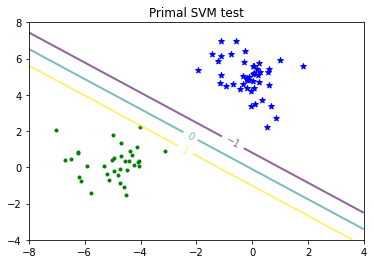

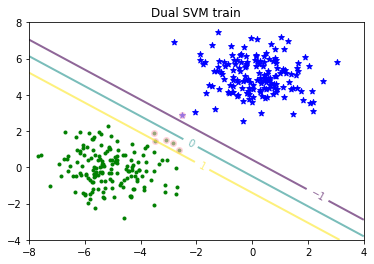

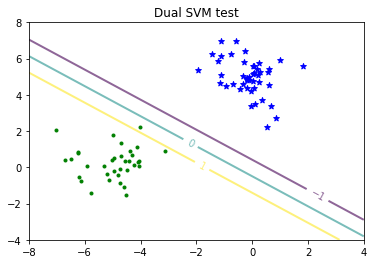

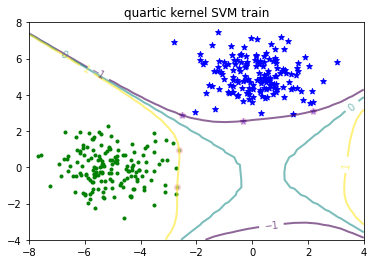

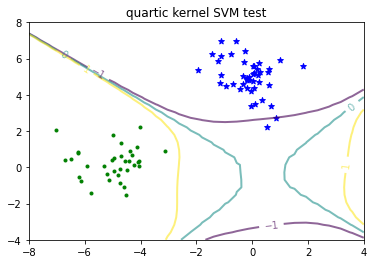

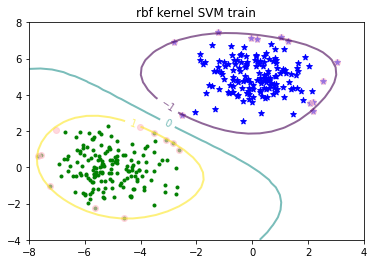

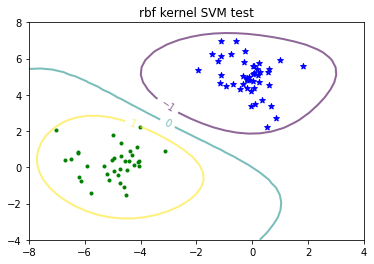

In [7]:
# fn=PolynomialFeatures(degree=2,include_bias=False)
def algorithm(train_data,test_data,axes):
    # primal svm
    model = Primal_SVM()
    model.fit(train_data)

    plt.figure()
    plot_svm_res(train_data,model,axes,plot_sv=False)
    plt.title('Primal SVM train')

    plt.figure()
    plot_svm_res(test_data,model,axes,plot_sv=False)
    plt.title('Primal SVM test')

    print('primal svm train accuracy:',model.eval(test_data[0],test_data[1]))
    print('primal svm test accuracy:',model.eval(test_data[0],test_data[1]))


    # dual svm
    model = Dual_SVM()
    model.fit(train_data)

    plt.figure()
    plot_svm_res(train_data,model,axes)
    plt.title('Dual SVM train')

    plt.figure()
    plot_svm_res(test_data,model,axes,plot_sv=False)
    plt.title('Dual SVM test')

    print('Dual SVM train accuracy:',model.eval(test_data[0],test_data[1]))
    print('Dual SVM test accuracy:',model.eval(test_data[0],test_data[1]))


    # kernel svm
    # quartic polynomial feature 
    model = Kernel_SVM('quartic')
    model.fit(train_data)

    plt.figure()
    plot_svm_res(train_data,model,axes)
    plt.title('quartic kernel SVM train')

    plt.figure()
    plot_svm_res(test_data,model,axes,plot_sv=False)
    plt.title('quartic kernel SVM test')

    print('quartic kernel SVM train accuracy:',model.eval(test_data[0],test_data[1]))
    print('quartic kernel SVM test accuracy:',model.eval(test_data[0],test_data[1]))


    #kernel svm
    # rbf kernel
    model=Kernel_SVM('rbf')
    model.fit(data,gamma=0.1)

    plt.figure()
    plot_svm_res(train_data,model,axes)
    plt.title('rbf kernel SVM train')

    plt.figure()
    plot_svm_res(test_data,model,axes,plot_sv=False)
    plt.title('rbf kernel SVM test')

    print('rbf kernel SVM train accuracy:',model.eval(test_data[0],test_data[1]))
    print('rbf kernel SVM test accuracy:',model.eval(test_data[0],test_data[1]))

    
algorithm(train_data,test_data,axes)

 从结果图可以看出, 存在边界上的点不是支撑向量的情况, 即对应的alpha=0
# T3

     pcost       dcost       gap    pres   dres
 0:  7.4657e-02  1.9787e+02  1e+03  2e+00  1e+03
 1:  3.2303e-01 -1.5991e+02  1e+03  2e+00  1e+03
 2:  2.5075e-01  2.0363e+02  1e+03  2e+00  9e+02
 3:  1.1282e-02  3.0301e+03  1e+03  1e+00  8e+02
 4:  3.4503e-03  5.8550e+03  2e+03  1e+00  8e+02
 5:  3.8524e-04  1.6948e+04  3e+03  1e+00  7e+02
 6:  5.5445e-05  7.7693e+04  6e+03  1e+00  6e+02
 7:  1.9968e-06  1.0570e+06  6e+03  1e+00  6e+02
 8:  2.4319e-07  1.2147e+08  3e+05  1e+00  6e+02
 9:  6.7450e-09  4.8418e+10  2e+07  1e+00  6e+02
10:  2.1476e-12  1.3483e+14  9e+08  1e+00  6e+02
11:  2.2197e-16  2.1133e+19  1e+12  1e+00  1e+04
12:  2.2199e-20  3.2583e+26  2e+17  1e+00  6e+10
13:  2.2819e-24  5.0218e+35  3e+24  1e+00  3e+20
14:  4.9784e-23  2.9081e+44  2e+33  1e+00  1e-11
15:  4.3267e-23  2.3552e+52  2e+41  1e+00  6e+36
16:  4.7364e-23  2.5868e+61  2e+50  1e+00  1e+46
17:  3.8847e-23  8.1857e+67  5e+56  1e+00  5e+52
18:  4.2051e-23  8.5827e+76  6e+65  1e+00  2e+61
19:  3.5830e-23  2.65

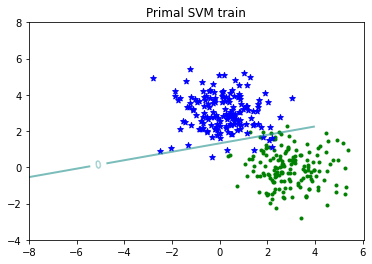

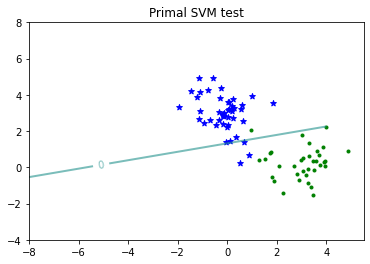

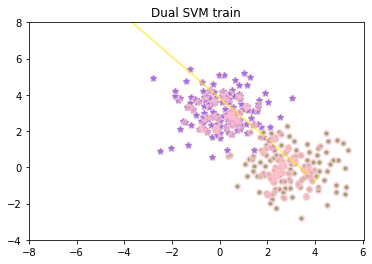

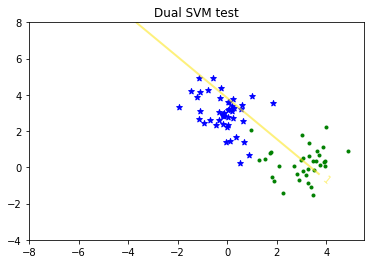

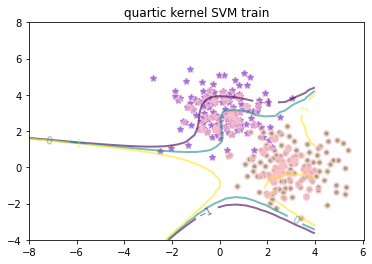

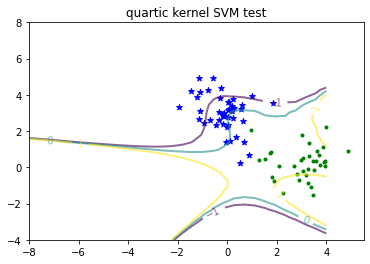

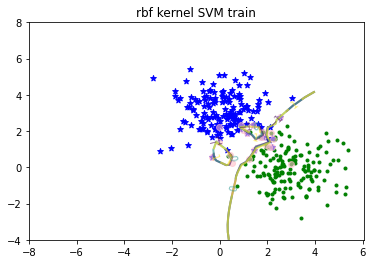

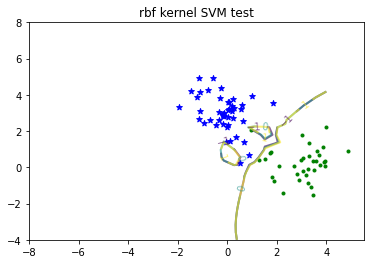

In [8]:
data=data_generator([3,0],np.eye(2),[0,3],np.eye(2),400,seed=SEED)
X_train,X_test,y_train,y_test=train_test_split(data[0],data[1],train_size=0.8,test_size=0.2)
train_data=(X_train,y_train)
test_data=(X_test,y_test)
algorithm(train_data, test_data, axes)

 由结果可见, 当数据难以线性区分时, 除了rbf核函数SVM外, 其他几种SVM的结果并不理想
# T4
## 尝试调节核函数中gamma的值

     pcost       dcost       gap    pres   dres
 0: -7.1142e+01 -1.8268e+02  1e+03  3e+01  2e+00
 1: -1.5578e+02 -3.0196e+02  1e+03  2e+01  2e+00
 2: -1.1833e+03 -1.9352e+03  1e+03  2e+01  2e+00
 3: -4.1296e+03 -4.9244e+03  9e+02  2e+01  1e+00
 4: -7.5381e+03 -8.7442e+03  1e+03  2e+01  1e+00
 5: -2.5191e+04 -2.7838e+04  3e+03  1e+01  1e+00
 6: -8.9304e+04 -9.6229e+04  7e+03  1e+01  1e+00
 7: -4.0831e+05 -4.3056e+05  2e+04  1e+01  1e+00
 8: -1.2216e+06 -1.2749e+06  5e+04  1e+01  1e+00
 9: -1.3904e+06 -1.4505e+06  6e+04  1e+01  1e+00
10: -1.5782e+06 -1.6457e+06  7e+04  1e+01  1e+00
11: -4.6577e+06 -4.8387e+06  2e+05  1e+01  1e+00
12: -5.2983e+06 -5.5033e+06  2e+05  1e+01  1e+00
13: -1.2870e+07 -1.3345e+07  5e+05  1e+01  1e+00
14: -1.3043e+07 -1.3525e+07  5e+05  1e+01  1e+00
15: -2.3606e+07 -2.4455e+07  8e+05  1e+01  1e+00
16: -2.6564e+07 -2.7510e+07  9e+05  1e+01  1e+00
17: -5.4571e+07 -5.6444e+07  2e+06  1e+01  1e+00
18: -5.5944e+07 -5.7861e+07  2e+06  1e+01  1e+00
19: -1.4933e+08 -1.54

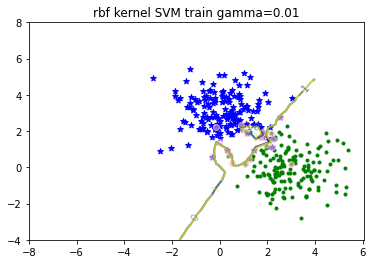

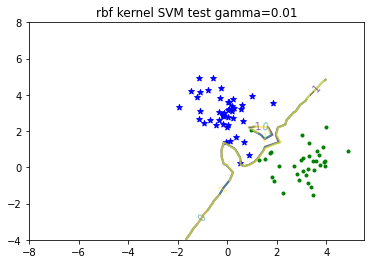

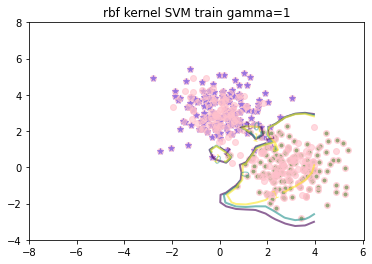

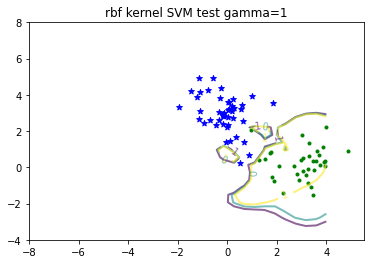

In [9]:
#kernel svm
# rbf kernel
model=Kernel_SVM('rbf')
model.fit(data,gamma=0.01)

plt.figure()
plot_svm_res(train_data,model,axes)
plt.title('rbf kernel SVM train gamma=0.01')

plt.figure()
plot_svm_res(test_data,model,axes,plot_sv=False)
plt.title('rbf kernel SVM test gamma=0.01')

print('rbf kernel SVM train accuracy:',model.eval(test_data[0],test_data[1]))
print('rbf kernel SVM test accuracy:',model.eval(test_data[0],test_data[1]))

model=Kernel_SVM('rbf')
model.fit(data,gamma=1)

plt.figure()
plot_svm_res(train_data,model,axes)
plt.title('rbf kernel SVM train gamma=1')

plt.figure()
plot_svm_res(test_data,model,axes,plot_sv=False)
plt.title('rbf kernel SVM test gamma=1')

print('rbf kernel SVM train accuracy:',model.eval(test_data[0],test_data[1]))
print('rbf kernel SVM test accuracy:',model.eval(test_data[0],test_data[1]))

 可见随着gamma的变小, 分类面也会变得更加平滑
## 尝试调节数据量的大小

     pcost       dcost       gap    pres   dres
 0:  7.8487e-02  2.7079e+01  1e+02  2e+00  1e+02
 1:  3.2838e-01  1.4790e+01  9e+01  1e+00  8e+01
 2:  1.1135e-01  1.6841e+02  1e+02  1e+00  7e+01
 3:  1.0036e-03  7.0007e+02  1e+02  1e+00  6e+01
 4:  1.8775e-05  4.5441e+03  1e+02  1e+00  6e+01
 5:  9.7222e-06  2.9304e+04  5e+02  1e+00  6e+01
 6:  4.5461e-06  4.0878e+05  6e+03  1e+00  6e+01
 7:  2.2353e-07  2.2334e+07  8e+04  1e+00  5e+01
 8:  1.7189e-10  6.2370e+09  7e+05  1e+00  5e+01
 9:  2.4154e-14  5.8939e+13  7e+07  1e+00  5e+01
10:  2.4771e-18  4.6078e+19  6e+11  1e+00  1e+04
11:  1.2155e-21  3.5317e+27  6e+17  1e+00  2e+12
12:  1.7563e-23  1.9073e+37  1e+26  1e+00  5e+21
13:  2.8916e-23  8.0318e+45  4e+34  1e+00  1e+30
14:  1.8859e-23  3.4688e+54  2e+43  1e+00  4e+38
15:  3.8696e-23  1.5033e+63  8e+51  1e+00  4e+47
16:  3.0973e-24  2.2194e+71  1e+60  1e+00  2e+55
17:  3.4292e-23  5.1003e+79  3e+68  1e+00  1e+64
18:  4.9469e-23  8.4373e+85  5e+74  1e+00  5e+71
19:  7.0671e-23  3.28

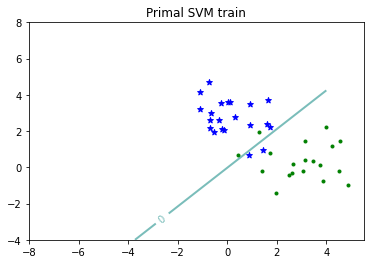

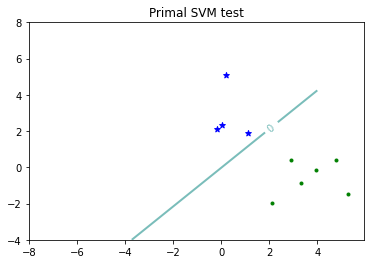

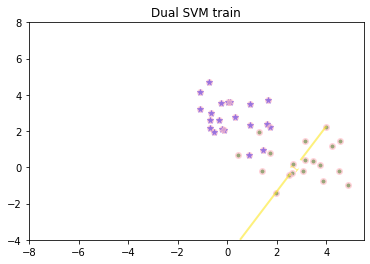

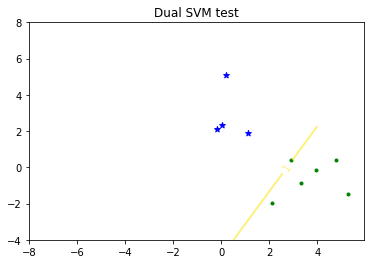

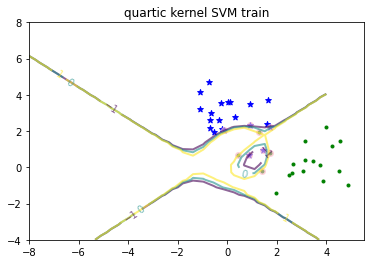

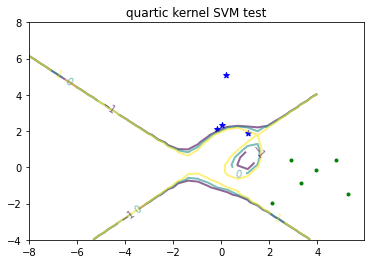

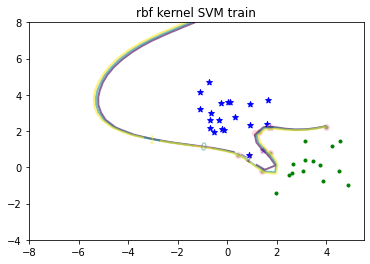

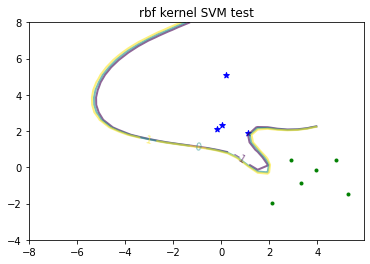

In [10]:
data=data_generator([3,0],np.eye(2),[0,3],np.eye(2),50,seed=SEED)
X_train,X_test,y_train,y_test=train_test_split(data[0],data[1],train_size=0.8,test_size=0.2)
train_data=(X_train,y_train)
test_data=(X_test,y_test)
algorithm(train_data, test_data, axes)

 可见随着样本数量的减少, 数据变得更加线性可分后, 分类效果也有所好转, 同时rbf核SVM与四次核SVM效果均较为理想
# T5

     pcost       dcost       gap    pres   dres
 0: -1.3230e+00 -2.3742e+00  3e+01  5e+00  1e+00
 1: -9.9076e-01 -5.2166e-01  5e+00  1e+00  3e-01
 2: -1.1995e-02 -1.7384e-04  2e-01  3e-02  9e-03
 3: -1.4269e-04 -3.0382e-05  2e-03  4e-04  1e-04
 4: -2.4644e-05 -1.6925e-05  3e-04  5e-05  1e-05
 5: -1.2292e-06 -2.2903e-06  3e-05  3e-06  1e-06
 6:  2.9410e-07 -1.7126e-06  2e-06  4e-22  1e-13
 7: -2.6646e-07 -8.2611e-07  6e-07  1e-22  4e-14
 8: -6.1633e-07 -8.4720e-07  2e-07  8e-22  3e-14
 9: -6.9868e-07 -7.2017e-07  2e-08  2e-22  2e-14
Optimal solution found.
the predict label is  China


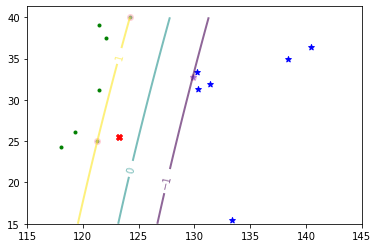

In [11]:
## 仅仅使用沿海城市

x1=[[119.28,26.08],#福州
[121.31,25.03],#台北
[121.47,31.23],#上海
[118.06,24.27],#厦门
[121.46,39.04],#大连
[122.10,37.50],#威海
[124.23,40.07]]#丹东

x2=[[129.87,32.75],#长崎
[130.33,31.36],#鹿儿岛
[131.42,31.91],#宫崎
[130.24,33.35],#福冈
[133.33,15.43],#鸟取
[138.38,34.98],#静冈
[140.47,36.37]]#水户  
X1=np.vstack((x1,x2))
y1=np.array([1.0]*7+[-1.0]*7)
data1=(X1,y1)

## 钓鱼岛坐标
x=np.array([123.28,25.45]).reshape((1,2))

axes=[115,145,15,40]

model=Kernel_SVM('square')
model.fit(data1)
plot_svm_res(data1,model,axes)
plt.scatter(x[0,0],x[0,1],color='red',marker='X')
label2desc={1:'China',-1:'Japan'}
print('the predict label is ',label2desc[int(model.predict(x))])

 从预测结果可见, 钓鱼岛是属于中国的
## 增加内陆城市

     pcost       dcost       gap    pres   dres
 0: -2.6873e+00 -5.2040e+00  4e+01  6e+00  2e+00
 1: -2.9112e+00 -1.6327e+00  1e+01  1e+00  4e-01
 2: -3.2298e-01 -2.7071e-02  1e+00  2e-01  5e-02
 3: -3.9486e-03 -2.5802e-05  2e-02  2e-03  6e-04
 4: -1.1727e-04 -2.0515e-05  5e-04  6e-05  2e-05
 5: -9.5005e-06 -1.8276e-06  4e-05  4e-06  1e-06
 6: -1.3364e-07 -1.5160e-06  1e-06  1e-09  3e-10
 7: -4.7164e-07 -8.7776e-07  4e-07  3e-10  9e-11
 8: -6.0351e-07 -7.9785e-07  2e-07  5e-11  1e-11
 9: -7.0618e-07 -7.1683e-07  1e-08  2e-12  6e-13
Optimal solution found.
the predict label is  China


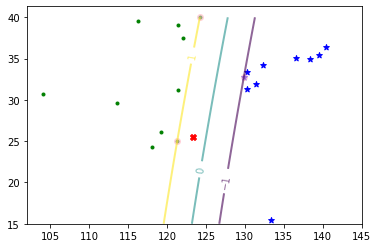

In [12]:
# 添加内陆城市

xp1=[[119.28,26.08],#福州
[121.31,25.03],#台北
[121.47,31.23],#上海
[118.06,24.27],#厦门
[113.53,29.58],#武汉
[104.06,30.67],#成都
[116.25,39.54],#北京
[121.46,39.04],#大连
[122.10,37.50],#威海
[124.23,40.07]]#丹东

xp2=[[129.87,32.75],#长崎
[130.33,31.36],#鹿儿岛
[131.42,31.91],#宫崎
[130.24,33.35],#福冈
[136.54,35.10],#名古屋
[132.27,34.24],#广岛
[139.46,35.42],#东京
[133.33,15.43],#鸟取
[138.38,34.98],#静冈
[140.47,36.37]]#水户
X2=np.vstack((xp1,xp2))
y2=np.array([1.0]*10+[-1.0]*10)
data2=(X2,y2)
model=Kernel_SVM('square')
model.fit(data2)
plot_svm_res(data2,model,axes)
plt.scatter(x[0,0],x[0,1],color='red',marker='X')
label2desc={1:'China',-1:'Japan'}
print('the predict label is ',label2desc[int(model.predict(x))])

 从图中标出的支撑向量可以看出, 增加的内陆城市对于预测并没有造成影响, 支撑向量未发生改变, 而且, 增加内陆城市并不影响分类结果, 钓鱼岛依旧是中国的